In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *

In [2]:
from post_processing import get_output

In [3]:
data = get_output('../outputs/test_interp.txt')

In [4]:
cond = data[data.asym_score < 0.9]

In [5]:
def _gauss(t,A,t0,sigma):
    """
    Function: Returns the value of a Gaussian distribution at a given time.

    Parameters:
        :t (float or array): Time or array of times at which to evaluate the Gaussian function.
        :A (float): Amplitude of the Gaussian peak.
        :t0 (float): Mean or centre of the Gaussian distribution.
        :sigma (float): Standard deviation or width of the Gaussian distribution.

    Returns:
        float or array: Value of the Gaussian function at the given time(s)."""

    return abs(A)*np.exp( -(t - t0)**2 / (2 * sigma**2) )

def _single_gaussian_curve_fit(x,y):

    assert not (np.isnan(y).any()), "y array contains NaN" 
    assert not (np.isinf(y).any()), "y array contains inf values" 

    """
    Function: Performs a curve fit to the Gaussian function given time and flux.

    Parameters:
        x (array): Independent variable (x-axis) values (time).
        y (array): Dependent variable (y-axis) values (flux).

    Returns:
        params, cov (tuple): The fitted parameters and the covariance matrix."""

    # Initial parameters guess
    i = np.argmax(y)
    A0 = y[i]
    mu0 = x[i]
    sigma0 = (x[-1]-x[0])/4

    params_bounds = [[0,x[0],0], [np.inf,x[-1],sigma0*4]]
    params,cov = curve_fit(gauss,x,y,[A0,mu0,sigma0],bounds=params_bounds)
    return params, cov

def _comet_curve(t,A,t0,sigma,tail):
    """
    Function: Calculates the values of an asymmetric Gaussian function representing a comet curve. 
    The difference is the exponential 1/tail term after the mid-transit.

    Parameters:
        t (array): Independent variable (time) values.
        A (float): Amplitude of the Gaussian curve.
        t0 (float): Mean (centre) of the Gaussian curve.
        sigma (float): Standard deviation of the Gaussian curve.
        tail (float): Tail parameter controlling decay rate after t0.

    Returns:
        array: The computed values of the asymmetric Gaussian curve."""

    x = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0:
            x[i] = gauss(t[i],A,t0,sigma)
        else:
            x[i] = A*math.exp(-abs(t[i]-t0)/tail)
    return x

def _comet_curve_fit(x,y):
    # Initial parameters guess
    # x = time
    # y = flux
    i = np.argmax(y)

    width = x[-1]-x[0]

    params_init = [y[i],x[i],width/3,width/3]

    params_bounds = [[0,x[0],0,0], [np.inf,x[-1],width/2,width/2]]
    params,cov = curve_fit(comet_curve,x,y,params_init,bounds=params_bounds)
    return params, cov

def _skewed_gaussian_curve_fit(x, y, y_err, width,gaussian_params):
    #, gaussian_params):
    """
    Fits a skewed Gaussian curve to the given data points based on parameters from a Gaussian fit.

    Parameters:
        x (array-like): time.
        y (array-like): light curve flux.
        y_err (array-like): Associated errors for light curve flux.
        width: duration of transit from the T-statistic.
        gaussian_params (list): Parameters from the Gaussian fit [A, t0, sigma]. This ensures that the symmetric fit is the "worst case scenario".

    Returns:
        tuple: A tuple containing two elements:
            - params (array-like): The optimized parameters of the skewed Gaussian curve fit.
            - cov (ndarray): The estimated covariance of the optimized parameters.
    """
    # Extract parameters from the Gaussian fit
    A_gaussian, t0_gaussian, sigma_gaussian = gaussian_params

    # Use Gaussian parameters as initial values for the skewed Gaussian fit
    params_init = [A_gaussian, t0_gaussian, sigma_gaussian, 0.001]  # Assuming initial skewness is 0
    #params_init = [y[i],x[i],width/3,width/3,0]
    # Define bounds for the parameters
    bounds = ([0, x[0], 0, -30], [np.inf, x[-1], np.inf, 30])

    # Perform skewed Gaussian fit using initial parameters
    params, cov = curve_fit(skewed_gaussian, x, y, sigma=y_err,p0=params_init, bounds=bounds) #sigma=y_err,

    return params, cov

def _skewed_gaussian(x, A, t0, sigma, alpha):
    """
    Skewed Gaussian function using the Skewed Student's t-distribution.

    Parameters:
        x: Input data points.
        A: Amplitude of the Gaussian.
        t0: Mean of the Gaussian.
        sigma: Standard deviation of the Gaussian.
        alpha: Skewness parameter (positive for right-skewed, negative for left-skewed).

    Returns:
        y: The value of the skewed Gaussian at each input data point x.
    """
    y = A * skewnorm.pdf(x,alpha,loc=t0, scale=sigma)
    return y


In [6]:
ids = cond.TIC_ID.values 

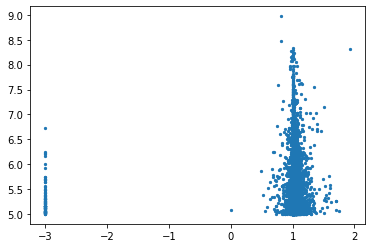

In [7]:
plt.scatter(data.asym_score,abs(data.snr),s=5)

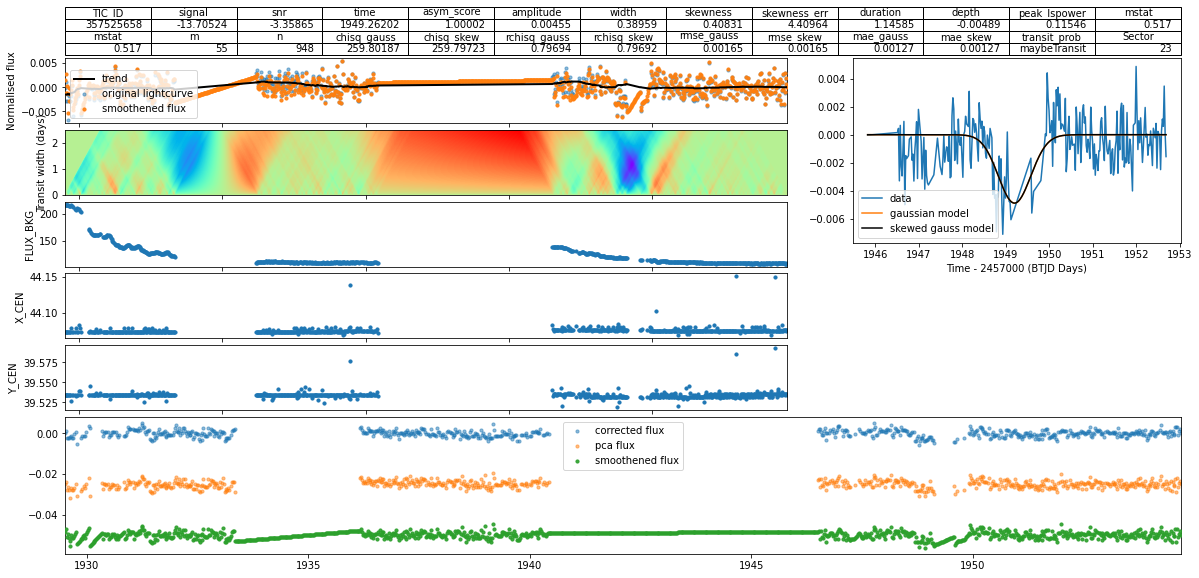

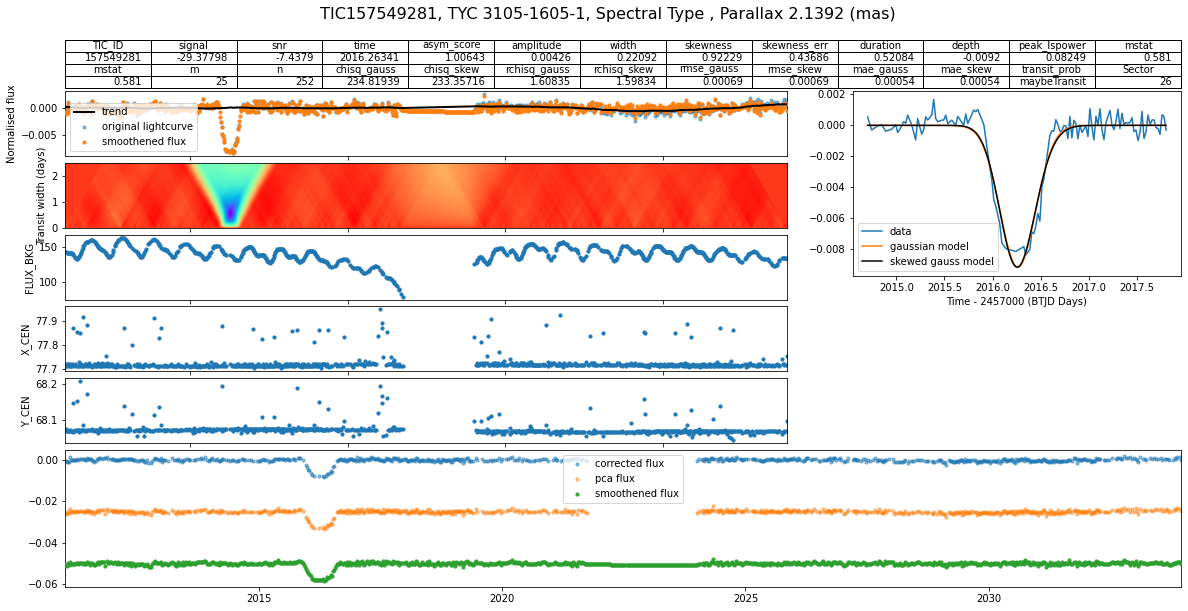

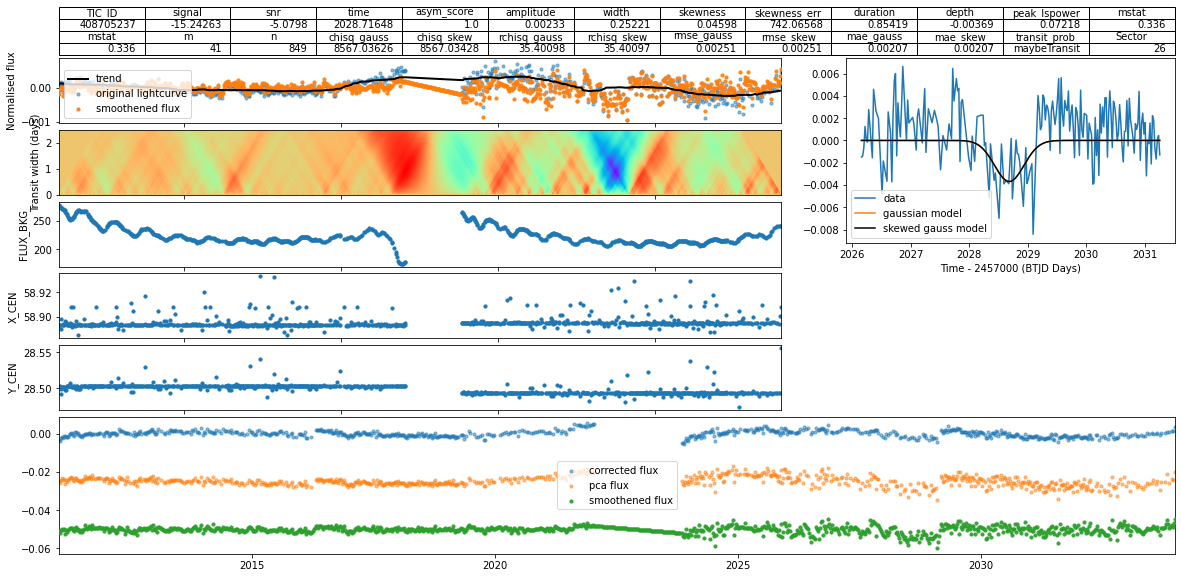

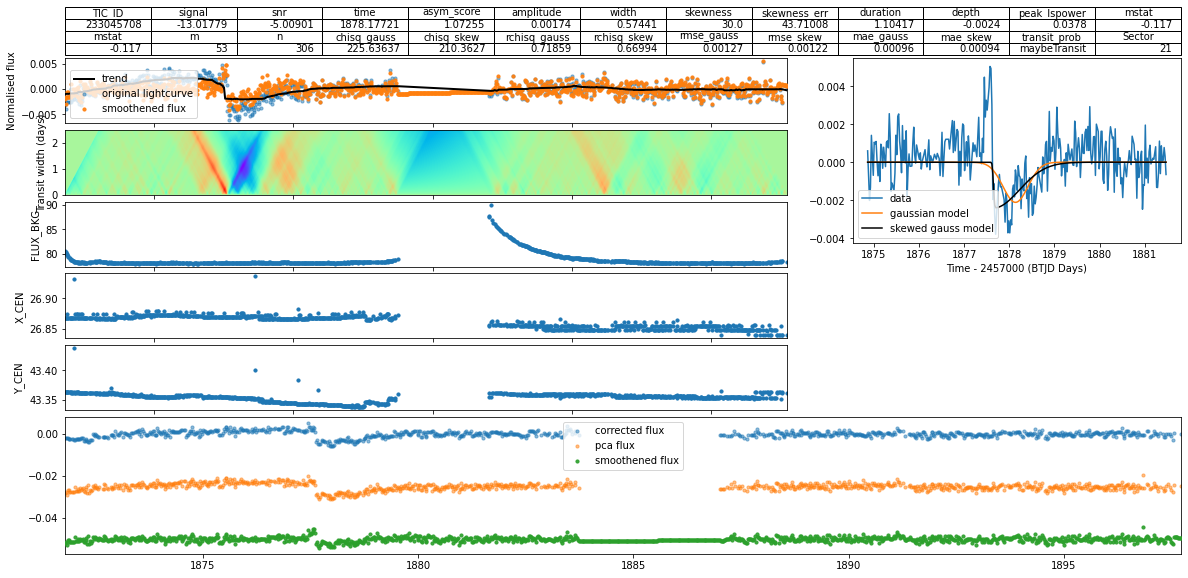

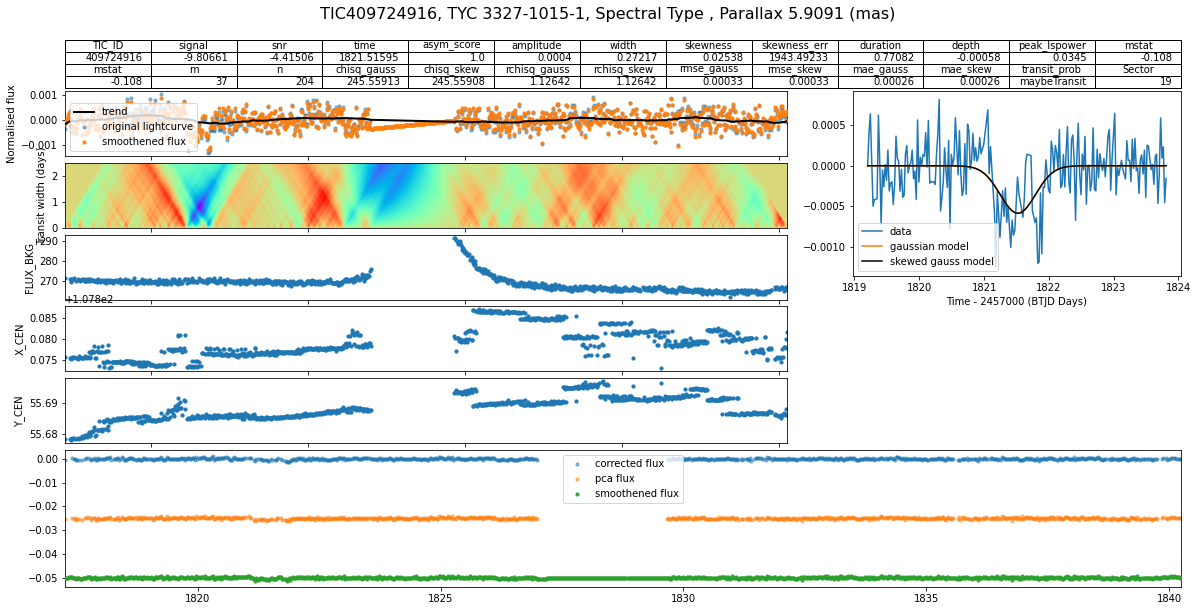

TypeError: 'int' object is not subscriptable

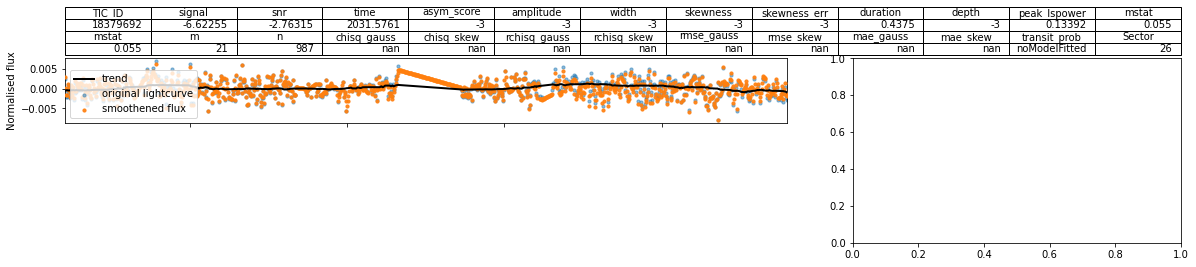

In [37]:
for i in cond.path.tail(10): #4 x 4 grid for illustration purposes
    #print(len(data_new[(data_new.asym_score >=0.9) & (data_new.asym_score <= 1) & (abs(data_new.depth) >= 0.1)]))
    lc, lc_info = import_lightcurve(i)
    lc = lc['TIME','PCA_FLUX','QUALITY','FLUX_ERR','FLUX_BKG','CORR_FLUX','X_CENTROID','Y_CENTROID']
    _, _ = processing(lc,lc_info=lc_info,method='median',make_plots=True)
    

In [10]:
from astropy.io import fits

In [33]:
cond.path.values[1]

'/storage/astro2/phrdhx/eleanor-lite-project-v2/s0001/hlsp_gsfc-eleanor-lite_tess_ffi_s0001-0000000441412317_tess_v1.0_lc.fits'

In [27]:
data, info = import_lightcurve(f'{cond.path.values[1]}')

In [32]:
data = data['TIME','PCA_FLUX','QUALITY','FLUX_ERR','CORR_FLUX','X_CENTROID','Y_CENTROID','FLUX_BKG']

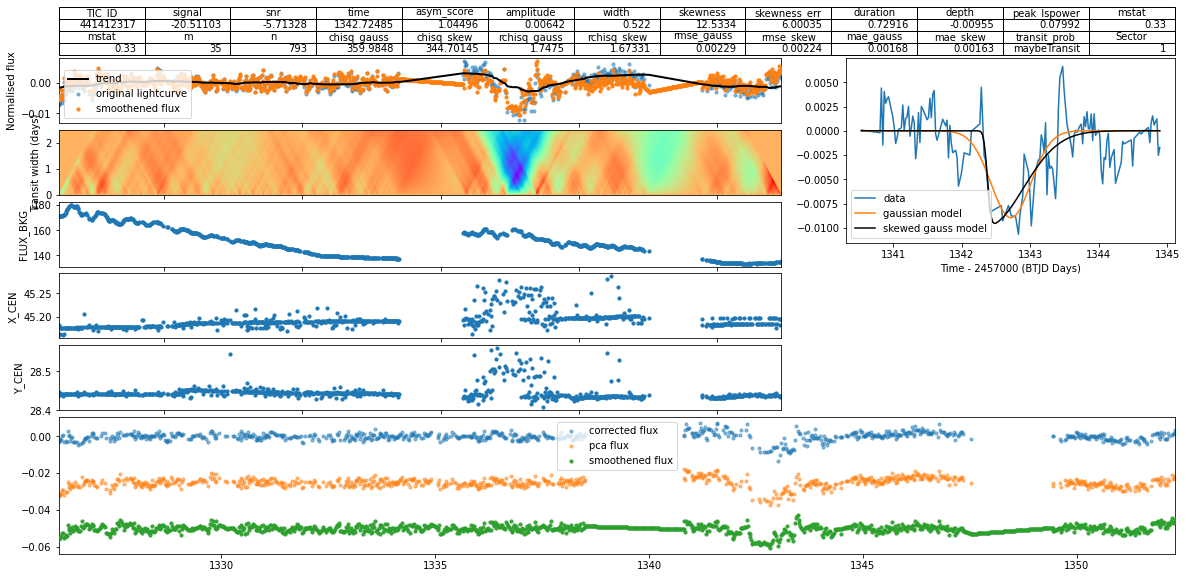

In [33]:
results, arrays = processing(data,lc_info=info,method='median',make_plots=True)

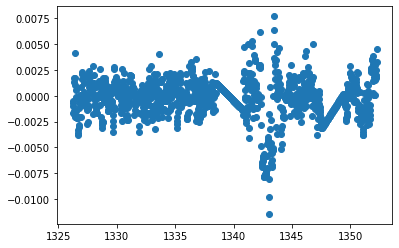

In [12]:
plt.scatter(arrays[0],arrays[1])

In [42]:
params3,cov3 = _skewed_gaussian_curve_fit(t,-f,fe,0.522,params1)

ValueError: operands could not be broadcast together with shapes (1253,) (148,) 

In [43]:
fit1 = -_gauss(t,*params1)

In [24]:
fit3 = -_skewed_gaussian(t,*params3)

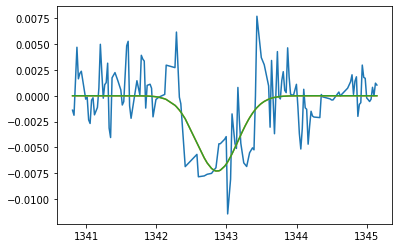

In [25]:
plt.plot(t,f)
plt.plot(t,fit1)
plt.plot(t,fit3)


---

In [38]:
test = get_output('../outputs/test_nointerp.txt')

In [54]:
paths = test[test.asym_score < 0].path

In [52]:
import pandas as pd

In [55]:
paths.to_csv('bad_fits.txt',index=False)